In [16]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, DataFrames, Statistics, MLJ, Plots, Clustering

In [25]:
# J = n of points
# I clusters
# D = dimension
# points[j,d]

### synthtic points

function generate_points(I,J,D, std, seed = 1234)
    Random.seed!(seed);
    X, yy = make_blobs(J, D; centers=I, cluster_std=std)
    points = Matrix(DataFrame(X));
    min = minimum(points, dims=1);
    max = maximum(points, dims=1);
    points = (points .- min) ./ (max .- min);
    return points
end

generate_points (generic function with 2 methods)

In [39]:
function manhattan_optimal_kmenas(points, I, J, D)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 300)

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= x[i,d] - points[j,d]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], 1000(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

function euclidean_optimal_kmenas(points,  I, J, D)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 300)

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model,[i=1:I, j=1:J, d=1:D], [y[j,d,i]; x[i,d] - points[j,d]] in SecondOrderCone())

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], 1000(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

euclidean_optimal_kmenas (generic function with 1 method)

In [36]:
#I,J,D = 3, 100, 2
#std = [1,2,3]

points = generate_points(3,100,2, [1,2,3], seed = 1234);
centroids, assigment, obj_value = manhattan_optimal_kmenas(points, I, J, D);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 250
Set parameter TimeLimit to value 250
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2500 rows, 1606 columns and 6000 nonzeros
Model fingerprint: 0x1c4a6757
Variable types: 1306 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+03]
Presolve removed 924 rows and 612 columns
Presolve time: 0.01s
Presolved: 1576 rows, 994 columns, 3852 nonzeros
Variable types: 694 continuous, 300 integer (300 binary)
Found heuristic solution: objective 46.7648104

Root relaxation: objective -5.216852e+01, 1023 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

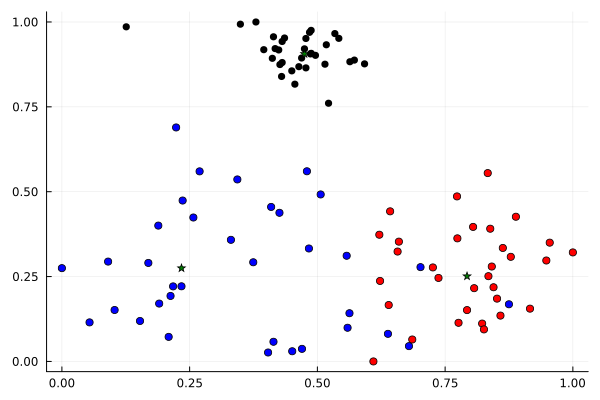

In [37]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [38]:
centroids, assigment, obj_value = euclidean_optimal_kmenas(points, I, J, D);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 250
Set parameter TimeLimit to value 250
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2500 rows, 2806 columns and 6000 nonzeros
Model fingerprint: 0x8d664330
Model has 600 quadratic constraints
Variable types: 2506 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+03]
Presolve removed 1022 rows and 1910 columns
Presolve time: 0.01s
Presolved: 1478 rows, 896 columns, 3888 nonzeros
Variable types: 596 continuous, 300 integer (300 binary)
Found heuristic solution: objective 45.9687349

Root relaxation: objective -6.395806e+04, 967 iterations, 0.01 seconds (0.02 work units)

    Node

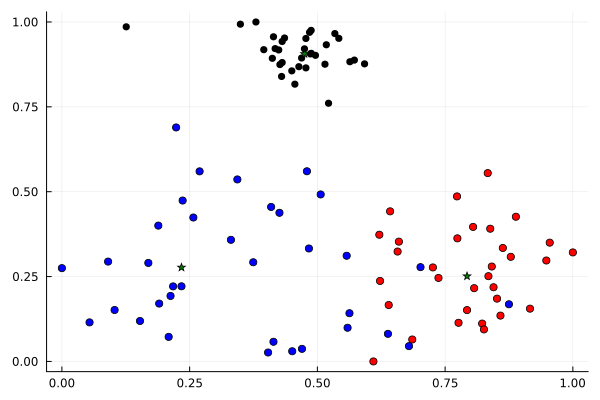

In [40]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

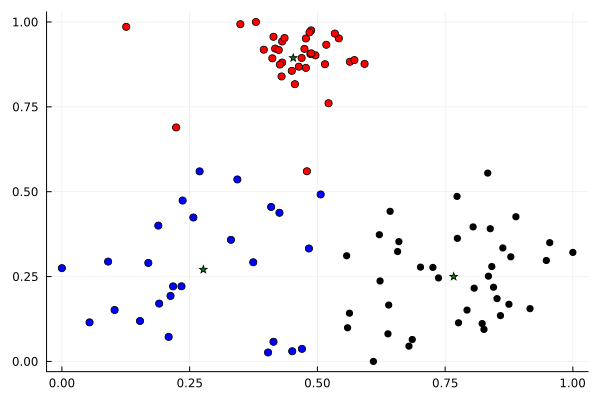

In [41]:
km = kmeans(points', 3);
centroids = km.centers';
assignments = km.assignments;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)